# 基于熵的数据离散化&单个分类器

In [16]:
#Import the Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#Importing the Dataset
Dataset = pd.read_csv("../code/Data/german/data.csv")

In [17]:
X = Dataset.iloc[:, -21:-1]
y = Dataset.iloc[:, [-1]]
columns_label=['A1','A3','A2','A4','A5','A6','A14','A7','A12','A10','A9','A20','A15','A8','A11','A17','A16','A19','A13','A18']
X=pd.DataFrame(X,columns=columns_label[0:20])

## 1.基于熵的离散化

In [18]:
# 数据离散化
''
import numpy as np
import math
 
class DiscreateByEntropy:
    def __init__(self, group, threshold):
        self.maxGroup = group # 最大分组数
        self.minInfoThreshold = threshold # 停止划分的最小熵
        self.result = dict()
 
    def loadData(self,title):
        data = np.column_stack((X[title],y))
        return data
 
    # 计算按照数据指定数据分组后的Shannon熵
    def calEntropy(self, data):
        numData = len(data)
        labelCounts = {}
        for feature in data:
            # 获得标签,这里只有0或者1
            oneLabel = feature[-1]
            # 设置字典中，标签的默认值
            if labelCounts.get(oneLabel,-1) == -1:
                labelCounts[oneLabel] = 0
            # 统计同类标签的数量
            labelCounts[oneLabel] += 1
        shannoEnt = 0.0
        for key in labelCounts:
            # 同类标签出现的概率,某一标签出现的次数除以所有标签的数量
            prob = float(labelCounts[key])/numData
            # 求熵，以2为底，取对数
            shannoEnt -= prob * math.log2(prob)
        return shannoEnt
 
    # 按照调和信息熵最小化原则分割数据集
    def split(self, data):
        # inf为正无穷
        minEntropy = np.inf
        # 记录最终分割的索引
        index = -1
        # 按照第一列对数据进行排序
        sortData = data[np.argsort(data[:,0])]
        # print(sortData)
        # 初始化最终分割数据后的熵
        lastE1,lastE2 = -1, -1
        # 返回的数据区间，包括数据和对应的熵
        S1 = dict()
        S2 = dict()
        for i in range(len(data)):
            splitData1, splitData2 = sortData[:i+1], sortData[i+1:]
            # 计算信息熵
            entropy1, entropy2 = (
                self.calEntropy(splitData1),
                self.calEntropy(splitData2)
            )
            # 计算调和平均熵
            entropy = entropy1 * len(splitData1) / len(sortData) + entropy2 * len(splitData2) / len(sortData)
            if entropy < minEntropy:
                minEntropy = entropy
                index = i
                lastE1 = entropy1
                lastE2 = entropy2
        S1["entropy"] = lastE1
        S1["data"] = sortData[:index+1]
        S2["entropy"] = lastE2
        S2["data"] = sortData[index+1:]
        return S1, S2, entropy
 
    def train(self,data):
        # 需要遍历的key
        needSplitKey = [0]
 
        self.result.setdefault(0,{})
        self.result[0]["entropy"] = np.inf
        self.result[0]["data"] = data
 
        group = 1
        for key in needSplitKey:
            S1, S2, entropy = self.split(self.result[key]["data"])
            if entropy > self.minInfoThreshold and group < self.maxGroup:
                self.result[key] = S1
                newKey = max(self.result.keys()) + 1
                self.result[newKey] = S2
                needSplitKey.extend([key])
                needSplitKey.extend([newKey])
                group += 1
            else:
                break
 
if __name__ == '__main__':
    for title in ['A2','A5','A13']:
        try:
            dbe = DiscreateByEntropy(group=2,threshold=0.5)
            data = dbe.loadData(title)
            dbe.train(data)
            # print("result is {}".format(dbe.result))
            sort=len(dbe.result.keys())
            for i in dbe.result.keys():
                num_min=np.min(dbe.result[i]['data'][:,0])
                num_max=np.max(dbe.result[i]['data'][:,0])
                X[title].iloc[(X[title]>=num_min)&(X[title]<=num_max)]=-i
                # X[(X[title]>=num_min)&(X[title]<num_max)]=int(i)
            X[title]=-X[title]
        except KeyError:
            pass
        

In [19]:
# 选取前几列
# new_X = np.round(X.iloc[:,:])
new_X = X
# data_new=pd.concat([new_X,y],axis=1)
# data_new.to_csv('../code/Data/german/data_new.csv')

## 2.分类模型：实证研究

### 2.1 Logistic

In [20]:
# from sklearn.model_selection import ShuffleSplit
# from sklearn import svm
# from sklearn.metrics import confusion_matrix, accuracy_score, f1_score

# max,lab=0,0
# for i in range(1,6):
#     new_X = X.iloc[:, :-i]
#     ss = ShuffleSplit(n_splits=10, test_size=0.3, random_state=0)
#     acc_train_all,f1_train_all,acc_test_all,f1_test_all=0,0,0,0
#     for train_index, test_index in ss.split(new_X):
#         X_train_svm , X_test_svm, y_train_svm, y_test_svm=new_X.iloc[train_index],new_X.iloc[test_index],y.iloc[train_index],y.iloc[test_index]
#         # print(X_train_2[1,''])
#         regr = svm.SVC(gamma='auto')
#         regr.fit(X_train_svm, y_train_svm)
#         y_pred_svm=regr.predict(X_test_svm)

#         acc_train_svm = accuracy_score(y_train_svm, regr.predict(X_train_svm))
#         f1_train_svm = f1_score(y_train_svm, regr.predict(X_train_svm), average= 'weighted')
#         acc_train_all+=acc_train_svm
#         f1_train_all+=f1_train_svm

#         #evaluate with test set
#         acc_test_svm = accuracy_score(y_test_svm, y_pred_svm)
#         f1_test_svm = f1_score(y_test_svm, y_pred_svm, average= 'weighted')
#         acc_test_all+=acc_test_svm
#         f1_test_all+=f1_test_svm
#     if max<(acc_test_all/10):
#         max=acc_test_all/10
#         lab=i
#     else:
#         pass
# print("ACCURACY for test set:",max)
# print("label:",lab)

# print("Training set results")
# print("ACCURACY for train set",acc_train_all/5)
# print("F1 SCORE for train set",f1_train_all/5)
# print("Testing set results")
# print("ACCURACY for test set",acc_test_all/5)
# print("F1 SCORE for test set",f1_test_all/5)

In [21]:
from sklearn.model_selection import ShuffleSplit
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score

ss = ShuffleSplit(n_splits=10, test_size=0.3, random_state=0)
acc_train_all,f1_train_all,acc_test_all,f1_test_all=0,0,0,0
for train_index, test_index in ss.split(new_X):
    # print("TRAIN:", train_index, "TEST:", test_index)
    X_train_log , X_test_log, y_train_log, y_test_log=new_X.iloc[train_index],new_X.iloc[test_index],y.iloc[train_index],y.iloc[test_index]
    # print(X_train_log[1,''])
    classifier = LogisticRegression(random_state =0)
    classifier.fit(X_train_log, y_train_log)
    #predict with test set
    y_pred_log = classifier.predict(X_test_log)
    #evaluating our model.
    
    acc_train_log = accuracy_score(y_train_log, classifier.predict(X_train_log))
    f1_train_log = f1_score(y_train_log, classifier.predict(X_train_log), average= 'weighted')
    acc_train_all+=acc_train_log
    f1_train_all+=f1_train_log
    #evaluate with test set
    acc_test_log = accuracy_score(y_test_log, y_pred_log)
    f1_test_log = f1_score(y_test_log, y_pred_log, average= 'weighted')
    acc_test_all+=acc_test_log
    f1_test_all+=f1_test_log

print("Training set results")
print("ACCURACY for train set",acc_train_all/10)
print("F1 SCORE for train set",f1_train_all/10)
print("Testing set results")
print("ACCURACY for test set",acc_test_all/10)
print("F1 SCORE for test set",f1_test_all/10)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the d

### 2.2 SVM

In [22]:
from sklearn import svm
from sklearn.model_selection import ShuffleSplit
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score

ss = ShuffleSplit(n_splits=10, test_size=0.3, random_state=0)
acc_train_all,f1_train_all,acc_test_all,f1_test_all=0,0,0,0
for train_index, test_index in ss.split(new_X):
    X_train_svm , X_test_svm, y_train_svm, y_test_svm=new_X.iloc[train_index],new_X.iloc[test_index],y.iloc[train_index],y.iloc[test_index]
    # print(X_train_2[1,''])
    regr = svm.SVC(gamma='auto')
    regr.fit(X_train_svm, y_train_svm)
    y_pred_svm=regr.predict(X_test_svm)

    acc_train_svm = accuracy_score(y_train_svm, regr.predict(X_train_svm))
    f1_train_svm = f1_score(y_train_svm, regr.predict(X_train_svm), average= 'weighted')
    acc_train_all+=acc_train_svm
    f1_train_all+=f1_train_svm

    #evaluate with test set
    acc_test_svm = accuracy_score(y_test_svm, y_pred_svm)
    f1_test_svm = f1_score(y_test_svm, y_pred_svm, average= 'weighted')
    acc_test_all+=acc_test_svm
    f1_test_all+=f1_test_svm

print("Training set results")
print("ACCURACY for train set",acc_train_all/10)
print("F1 SCORE for train set",f1_train_all/10)
print("Testing set results")
print("ACCURACY for test set",acc_test_all/10)
print("F1 SCORE for test set",f1_test_all/10)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

### 2.3 Decision Trees

In [23]:
from sklearn import tree
from sklearn.model_selection import ShuffleSplit
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score

ss = ShuffleSplit(n_splits=10, test_size=0.3, random_state=0)
acc_train_all,f1_train_all,acc_test_all,f1_test_all=0,0,0,0
for train_index, test_index in ss.split(new_X):
    X_train_tree , X_test_tree, y_train_tree, y_test_tree=new_X.iloc[train_index],new_X.iloc[test_index],y.iloc[train_index],y.iloc[test_index]
    # print(X_train_2[1,''])
    clf = tree.DecisionTreeClassifier()
    clf = clf.fit(X_train_tree, y_train_tree)
    y_pred_tree=clf.predict(X_test_tree)

    acc_train_tree = accuracy_score(y_train_tree, clf.predict(X_train_tree))
    f1_train_tree = f1_score(y_train_tree, clf.predict(X_train_tree), average= 'weighted')
    acc_train_all+=acc_train_tree
    f1_train_all+=f1_train_tree

    #evaluate with test set
    acc_test_tree = accuracy_score(y_test_tree, y_pred_tree)
    f1_test_tree = f1_score(y_test_tree, y_pred_tree, average= 'weighted')
    acc_test_all+=acc_test_tree
    f1_test_all+=f1_test_tree

print("Training set results")
print("ACCURACY for train set",acc_train_all/10)
print("F1 SCORE for train set",f1_train_all/10)
print("Testing set results")
print("ACCURACY for test set",acc_test_all/10)
print("F1 SCORE for test set",f1_test_all/10)

Training set results
ACCURACY for train set 1.0
F1 SCORE for train set 1.0
Testing set results
ACCURACY for test set 0.7827050997782704
F1 SCORE for test set 0.7826561726557955


### 2.4 BP神经网络

In [24]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report,confusion_matrix

ss = ShuffleSplit(n_splits=10, test_size=0.3, random_state=0)
acc_train_all,f1_train_all,acc_test_all,f1_test_all=0,0,0,0
for train_index, test_index in ss.split(new_X):
    X_train_bp , X_test_bp, y_train_bp, y_test_bp=new_X.iloc[train_index],new_X.iloc[test_index],y.iloc[train_index],y.iloc[test_index]
    # print(X_train_2[1,''])
    mlp = MLPClassifier(hidden_layer_sizes=(100,50,20),max_iter=500)
    mlp.fit(X_train_bp, y_train_bp)
    y_pred_bp=mlp.predict(X_test_bp)

    acc_train_bp = accuracy_score(y_train_bp, clf.predict(X_train_bp))
    f1_train_bp = f1_score(y_train_bp, clf.predict(X_train_bp), average= 'weighted')
    acc_train_all+=acc_train_bp
    f1_train_all+=f1_train_bp

    #evaluate with test set
    acc_test_bp = accuracy_score(y_test_bp, y_pred_bp)
    f1_test_bp = f1_score(y_test_bp, y_pred_bp, average= 'weighted')
    acc_test_all+=acc_test_bp
    f1_test_all+=f1_test_bp

print("Training set results")
print("ACCURACY for train set",acc_train_all/10)
print("F1 SCORE for train set",f1_train_all/10)
print("Testing set results")
print("ACCURACY for test set",acc_test_all/10)
print("F1 SCORE for test set",f1_test_all/10)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

## 单模型验证

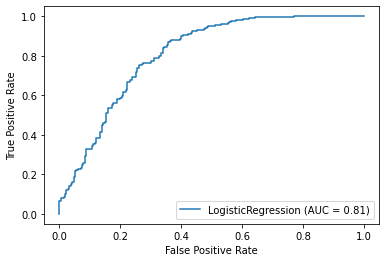

In [25]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import plot_roc_curve
from sklearn.datasets import load_wine

classifier_disp = plot_roc_curve(classifier, X_test_log, y_test_log)

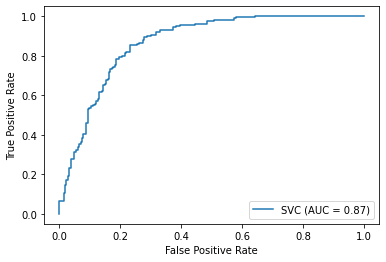

In [26]:
regr_disp = plot_roc_curve(regr, X_test_svm, y_test_svm)

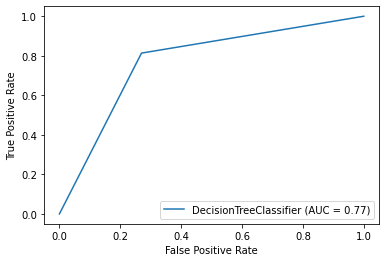

In [27]:
clf_disp = plot_roc_curve(clf, X_test_tree, y_test_tree)

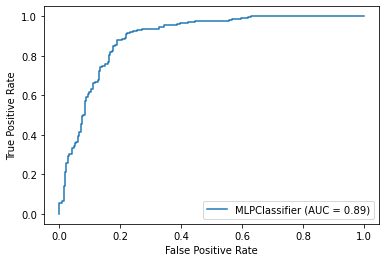

In [28]:
mlp_disp = plot_roc_curve(mlp, X_test_bp, y_test_bp)

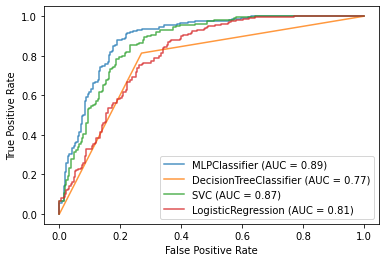

In [29]:
ax = plt.gca()
mlp_disp = plot_roc_curve(mlp,X_test_bp, y_test_bp, ax=ax, alpha=0.8)
clf_disp.plot(ax=ax, alpha=0.8)
regr_disp.plot(ax=ax, alpha=0.8)
classifier_disp.plot(ax=ax, alpha=0.8)

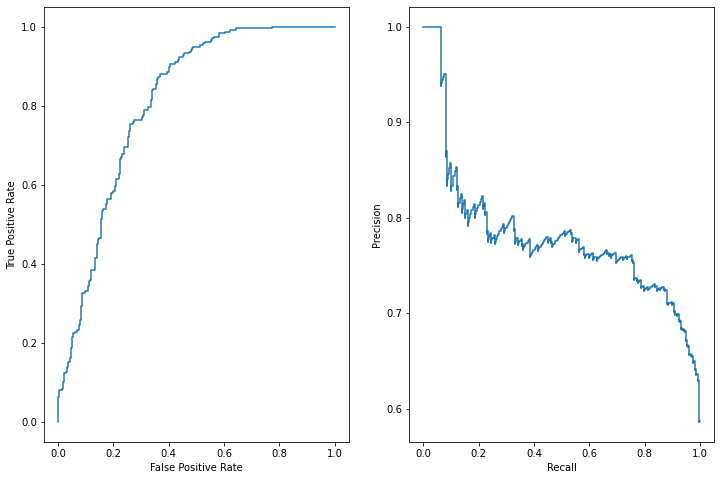

In [30]:
from sklearn.metrics import roc_curve
from sklearn.metrics import RocCurveDisplay

from sklearn.metrics import precision_recall_curve
from sklearn.metrics import PrecisionRecallDisplay

y_score = classifier.decision_function(X_test_log)

fpr, tpr, _ = roc_curve(y_test_log, y_score, pos_label=clf.classes_[1])
roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr)


prec, recall, _ = precision_recall_curve(y_test_log, y_score,pos_label=clf.classes_[1])
pr_display = PrecisionRecallDisplay(precision=prec, recall=recall)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8))

roc_display.plot(ax=ax1)
pr_display.plot(ax=ax2)
plt.show()